In [43]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(16, 4.2)

from util import util_at as util
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import xgboost
from sklearn.inspection import permutation_importance

import shap
import pickle
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Biomedical Data Analysis

### Introducing the Problem

## Biomedical Data Analysis

**Assume we are concated by a bio-medical lab**

<center>
<img src="assets/test_tubes.jpg" width=65%/>
</center>

* They have collected data about patients with a certain condition
* ...And they want to get a better _understanding_ of the involved process

## Our Dataset

**This use case is based on a real-world example**

...But for privacy and simplicity reasons we are going to use synthetic data

In [21]:
data, name_map = util.generate_data(size=500, seed=42)
data

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,y
0,0.0,4.052587,0.0,0.0,1.069842,-1.541433,0.984682,2.069759,-0.998354,1.615419,1.0,0.0,3.905281,1.422892,0.0,1.0
1,0.0,2.520945,1.0,0.0,-1.924131,-2.583550,4.663292,-1.633941,0.324484,0.426927,1.0,0.0,1.319270,1.771152,0.0,1.0
2,0.0,1.061444,0.0,1.0,0.288059,-0.974309,2.641967,0.823806,1.340944,1.498628,1.0,0.0,-1.072016,-0.750879,0.0,0.0
3,1.0,0.523647,1.0,1.0,1.824137,-2.841816,4.099077,-2.287757,1.230311,1.628930,1.0,1.0,1.299762,2.085999,1.0,1.0
4,0.0,2.010178,0.0,0.0,-0.050319,-2.620961,3.162254,-0.803245,-0.840076,0.507807,0.0,0.0,0.307414,-0.884796,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,7.434214,1.0,1.0,-1.948899,-1.283335,2.303599,0.505025,2.488334,1.713777,1.0,0.0,5.451237,0.257810,1.0,1.0
496,0.0,7.857776,1.0,0.0,0.239719,-1.181798,2.301580,-1.150514,-0.703677,2.100331,0.0,0.0,4.269326,0.760440,0.0,0.0
497,1.0,3.348010,0.0,0.0,0.147685,-2.541503,2.887376,-0.372831,1.435787,0.967976,0.0,0.0,0.576445,0.450504,0.0,0.0
498,1.0,2.784484,0.0,0.0,-2.082640,-1.224654,4.271790,-0.269379,0.876229,0.745919,1.0,1.0,0.424243,-1.446797,0.0,0.0


<div class=big>How do we start?</div>

## Our Dataset

**Let's have a first look at the dataset**

In [22]:
data.describe()

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.396000,1.828261,0.514000,0.330000,-0.030795,-1.420177,2.995727,-0.361947,0.449518,1.080533,0.596000,0.320000,0.983245,0.038664,0.308000,0.484000
std,0.489554,2.112032,0.500305,0.470684,1.440194,0.961449,1.008219,1.463672,0.980352,1.300855,0.491189,0.466943,1.938673,1.331953,0.462129,0.500244
min,0.000000,0.055230,0.000000,0.000000,-4.699421,-4.244599,0.033381,-5.647642,-3.000955,-2.883850,0.000000,0.000000,-5.630335,-3.950166,0.000000,0.000000
25%,0.000000,0.547481,0.000000,0.000000,-1.034566,-2.138448,2.289419,-1.295046,-0.186973,0.188749,0.000000,0.000000,-0.244988,-0.793562,0.000000,0.000000
50%,0.000000,1.127278,1.000000,0.000000,0.023120,-1.403097,3.044132,-0.320448,0.412165,1.058317,1.000000,0.000000,0.903468,0.020962,0.000000,0.000000
75%,1.000000,2.127061,1.000000,1.000000,0.927888,-0.836187,3.714111,0.561467,1.071871,1.974449,1.000000,1.000000,2.078707,0.872534,1.000000,1.000000
max,1.000000,13.486418,1.000000,1.000000,3.747794,1.706728,5.906263,4.334036,3.401382,5.526514,1.000000,1.000000,7.306814,5.549188,1.000000,1.000000


* There is one target binary variable $Y$, representing the condition under study
* All other columns represent potentially correlate variables
* We are going to refer to them as "potential correlates"

## Categorial and Numerical Variables

**Some of the potential correlates are numeric, others are categorical**

In [23]:
# Identify numeric and categorical columns
num_cols = [c for c in data.columns[:-1] if len(data[c].unique()) > 2]
cat_cols = [c for c in data.columns[:-1] if len(data[c].unique()) == 2]
print(f'Numeric: {num_cols}')
print(f'Categorical: {cat_cols}')

Numeric: ['u1', 'u4', 'u5', 'u6', 'u7', 'u8', 'u9', 'u12', 'u13']
Categorical: ['u0', 'u2', 'u3', 'u10', 'u11', 'u14']


* In this synthetic dataset, all categorical variables are binary
* ...Which explains the simple filter we used to identify them

In a real world setting, you'd need to talk to a domain expert for this

## Checking the Distributions

**Let's check the distribution of the _numerical_ candidate correlates**

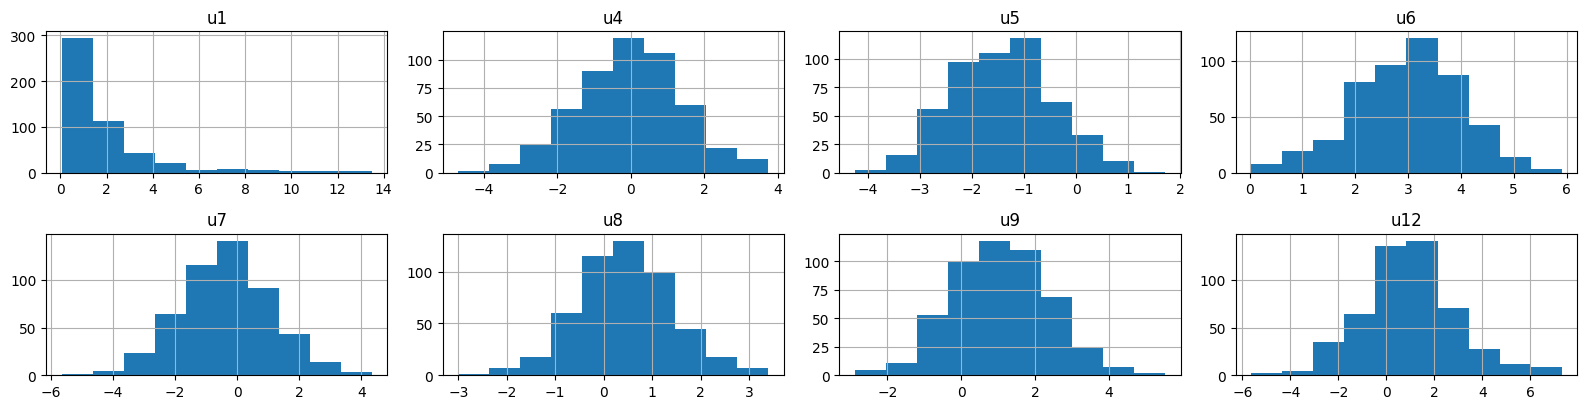

In [24]:
_, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(num_cols)//2)), figsize=figsize)
for ax, cname in zip(axes.ravel(), num_cols):
    data.hist(cname, ax=ax)
plt.tight_layout()

Most of them seem to follow a Normal distribution

## Checking the Distributions

**Let's check the distribution of the _binary_ candidate correlates**

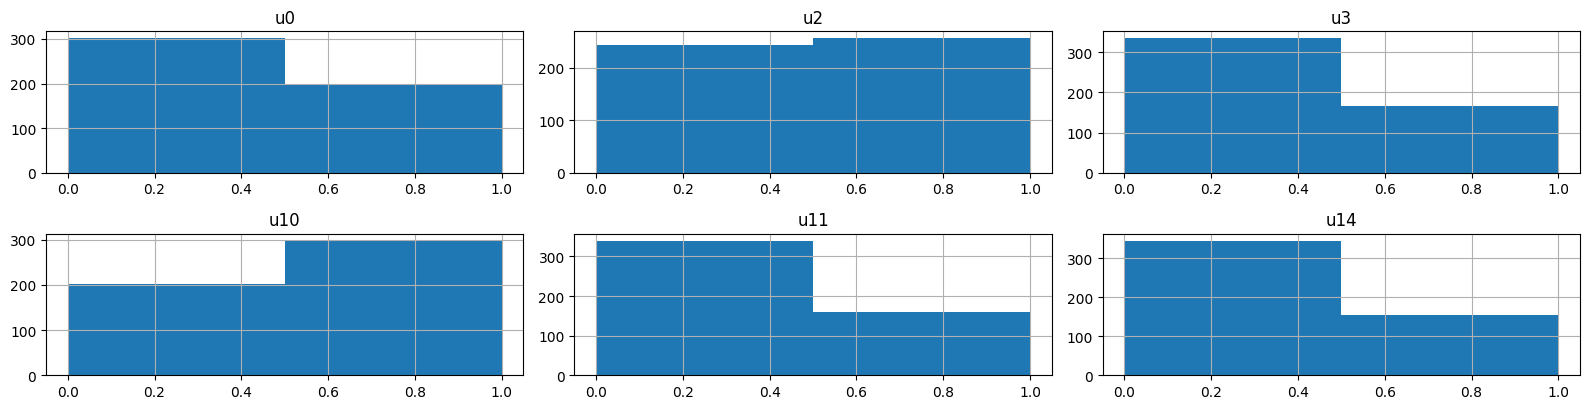

In [25]:
_, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(cat_cols)//2)), figsize=figsize)
for ax, cname in zip(axes.ravel(), cat_cols):
    data.hist(cname, ax=ax, bins=2)
plt.tight_layout()

Some are well balanced, othere less so

## Checking the Distributions

**Let's check the _target_ distribution**

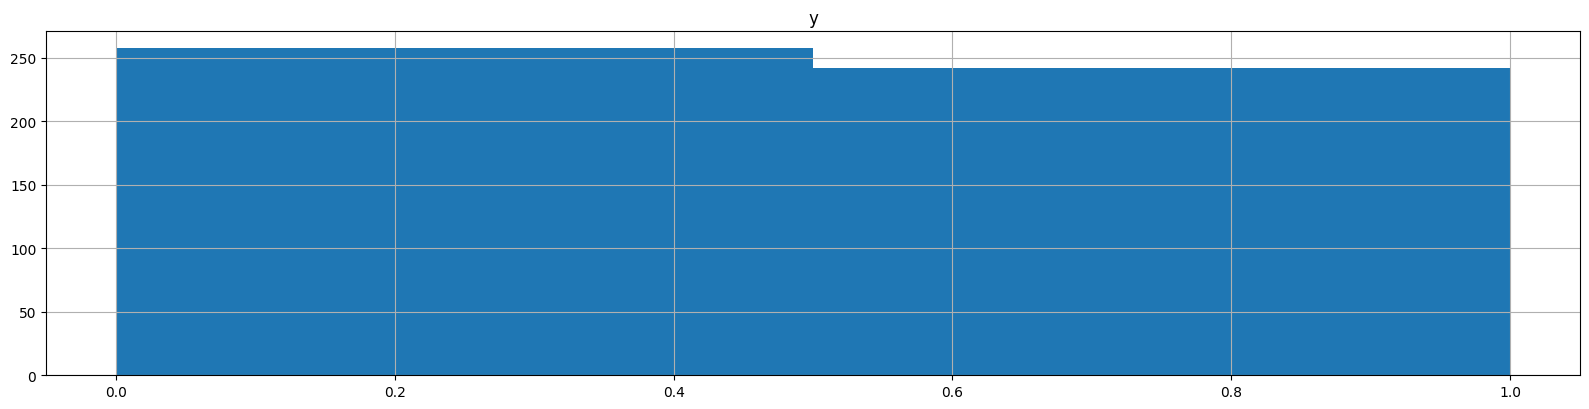

In [26]:
data.hist('y', bins=2, figsize=figsize)
plt.tight_layout()

The target distribution quite balanced

## Checking Univariate Dependencies

**Let's check the fraction of $Y=1$ for the _categorical_ candidates**

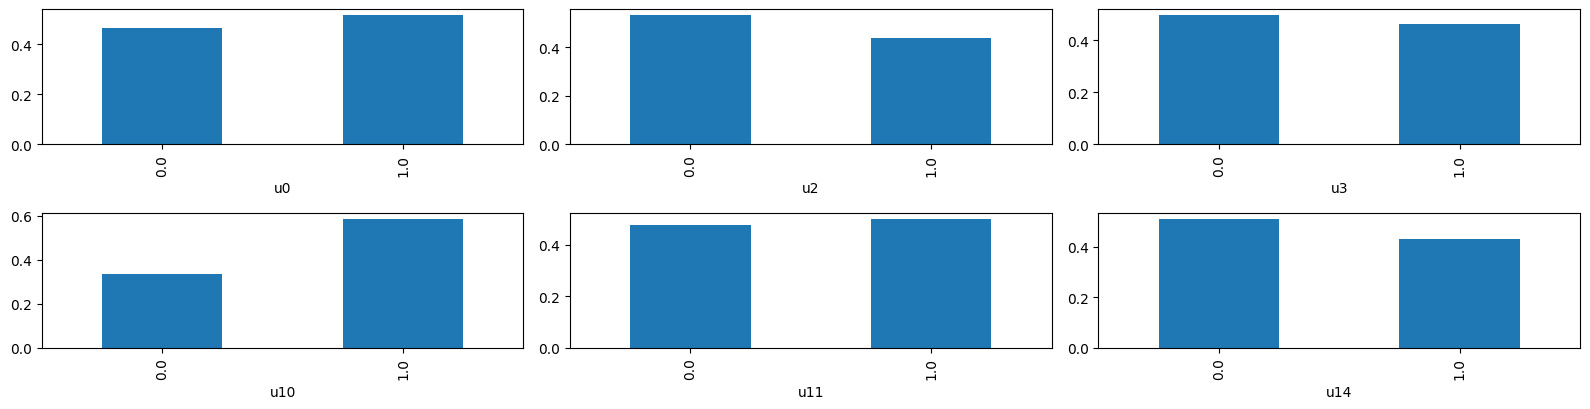

In [27]:
_, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(cat_cols)//2)), figsize=figsize)
for ax, cname in zip(axes.ravel(), cat_cols):
    data.groupby(cname)['y'].mean().plot.bar(ax=ax)
plt.tight_layout()

A few of them seems to have a correlation, other cases are less clear

## Checking Univariate Dependencies

**Let's check the fraction of $y=1$ for the _numerical_ candidates**

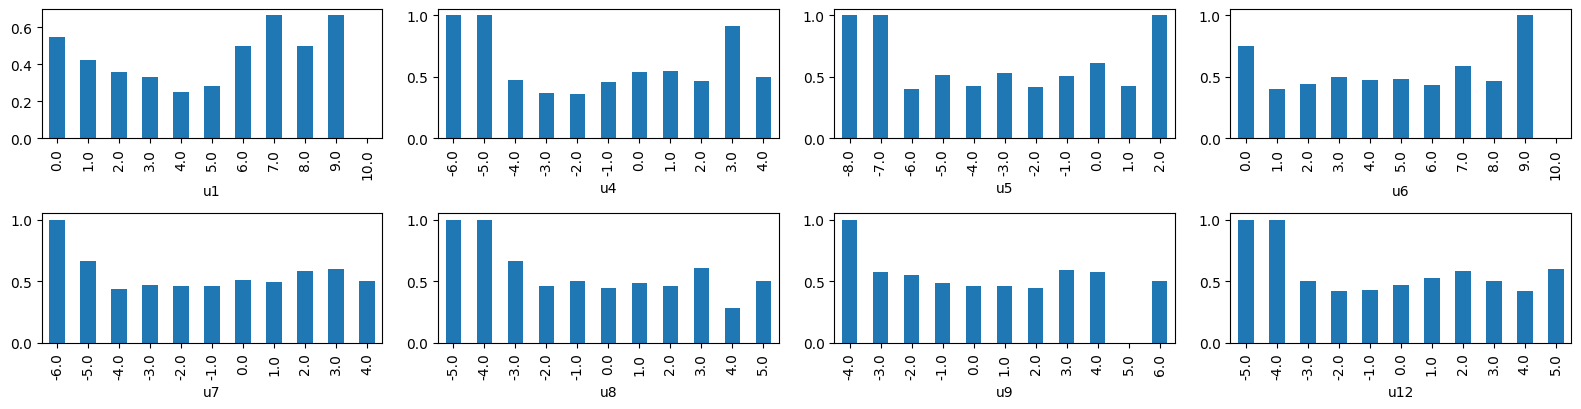

In [28]:
_, axes = plt.subplots(nrows=2, ncols=int(np.ceil(len(num_cols)//2)), figsize=figsize)
for ax, cname in zip(axes.ravel(), num_cols):
    bin_size = (data[cname].max() - data[cname].min()) / 10
    data['y'].groupby(data[cname] // bin_size).mean().plot.bar(ax=ax)
plt.tight_layout()

Most of them appear to have some non-linear correlation

## Checking Linear Correlations

**It's worth checking how all features are correlated**

One way to do it is by plotting a correlation matrix (e.g. Pearson)

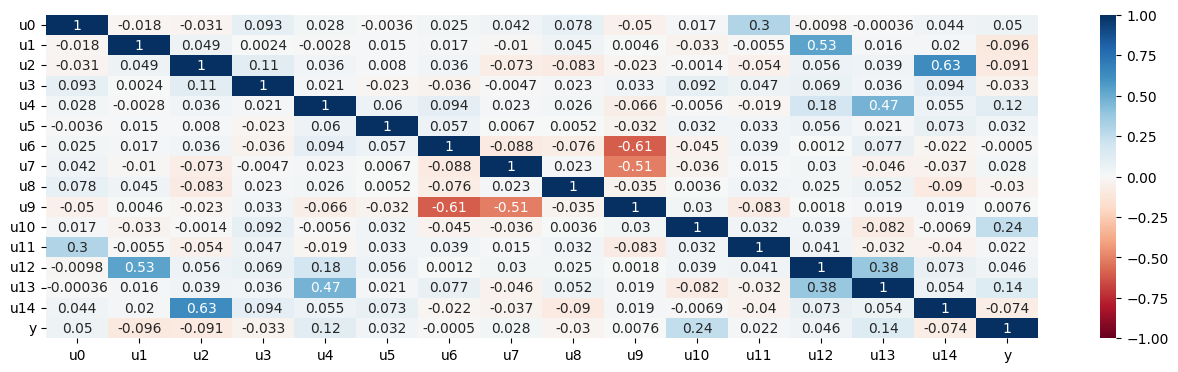

In [29]:
plt.figure(figsize=figsize)
sn.heatmap(data.corr(method='pearson'), annot=True, vmin=-1, vmax=1, cmap='RdBu');

* Sparse correlations in general, weak (linear) correlations for $Y$

<div class=big>
    <span class=small>So far we have just inspected our dataset, but...</span><br>
    what is exactly our goal?
</div>

## Use Case Objective

**Unlike in classical ML tasks, we don't have an _estimation_ problem**

Rather, our goal is _understanding_ the process behind the data

* We want to identify the true _correlates_ among our candidates
* We want to see _how_ they are linked to the target $y$

**In an ideal world, we'd like to know about _causal_ relationships**

...But in practice, we'll need to be happy with correlations

* Studying causality is indeed possible (a good start is [Judea Pearl's book](https://www.cambridge.org/core/journals/econometric-theory/article/causality-models-reasoning-and-inference-by-judea-pearl-cambridge-university-press-2000/DA2D9ABB0AD3DAC95AE7B3081FCDF139))
* ...But also very challenging, and there's no general and mature tool available

So, we'll count on the domain expert to check the correlations

## Use Case Objective

**Our setup also explains a quirk in the dataset**

All variables except the target are called $U_j$, for "unknown"

* This is synthetic data, so nothing is really unknown
* In fact, the ground truth process linking $Y$ to $U$ is avaialable

**However, for the sake of this exercise, such process will be hidden**

* We will analyze the data pretending we have no such knowledge
* _At the end_ of our exercise we'll check the ground truth

...And we'll see how close we got to the truth!

# Biomedical Data Analysis

### A Baseline Approach

## A Baseline Approach

**Our goal is _understading_ the process behind the data**

Of of many possible ways to do it consist in:

* Training an approximate model via Machine Learning
* Studying the model as a proxy for the real process

> **Basically, we use a ML model as an _analysis tool_**

**For this approach to work, we need the ML model to be _explainable_**

* A few model naturally enjoy this property (e.g. linear models, simple DTs)
* Explaining other models is not obvious (e.g. Neural Networks, large ensembles)

We will start with the simplest option: Logistic Regression

## Data Preprocessing

**We start with the usual data preprocessing**

We will treat all candidate correlates as inputs

In [30]:
# Input-output separation
X, y = data[data.columns[:-1]].copy(), data[data.columns[-1]].copy()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Input standardization
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Even if we don't care about estimates, we need a _test set_

* This will allow us to check the model for overfitting

We also need to standardize all numeric features

* This will make the model coefficients more easily interpretable

## On the Danger of Overfitting

**We plan to use our model as proxy for the true process**

...Which makes _overfitting is especially bad_

* Our results will stricly apply only to the model
* ...And they will be as general as the model

**We will use _L1 regularization_ on this purpose**

Scikit learn support L1 regularizers for Logistic Regression in the form:

$$
\mathop{\mathrm{argmin}_\theta} H(y, f(x, \theta)) + \frac{1}{C}\|\theta\|_1
$$

* We encourage the weights to be close to 0
* ...And we attempt to sparsify the weights

## Training our "Proxy" Model

**We can calibrate the $C$ parameter via cross-validation**

We'll need the [SAGA solver](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf) to train our model with L1 regularization

In [31]:
base_est = LogisticRegression(penalty='l1', solver='saga')
param_grid={'C': 1. / np.linspace(1e-1, 1e4, 100)}
gscv = GridSearchCV(base_est, param_grid=param_grid, scoring='roc_auc')
gscv.fit(X_train, y_train)
lr, lr_params = gscv.best_estimator_, gscv.best_params_

**Then we can check the performance of the refitted estimator**

In [32]:
lr_score_cv, lr_score_test = gscv.best_score_, roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
print(f'AUC score for C={lr_params["C"]:.2f}: {lr_score_cv:.2f} (cross-validation), {lr_score_test:.2f} (test)')

AUC score for C=10.00: 0.64 (cross-validation), 0.60 (test)


* We use the AUC score, since this is not a real classification problem
* There's no significant overfitting

## Coefficient Analysis

**Finally, we can analyze the model coefficients**

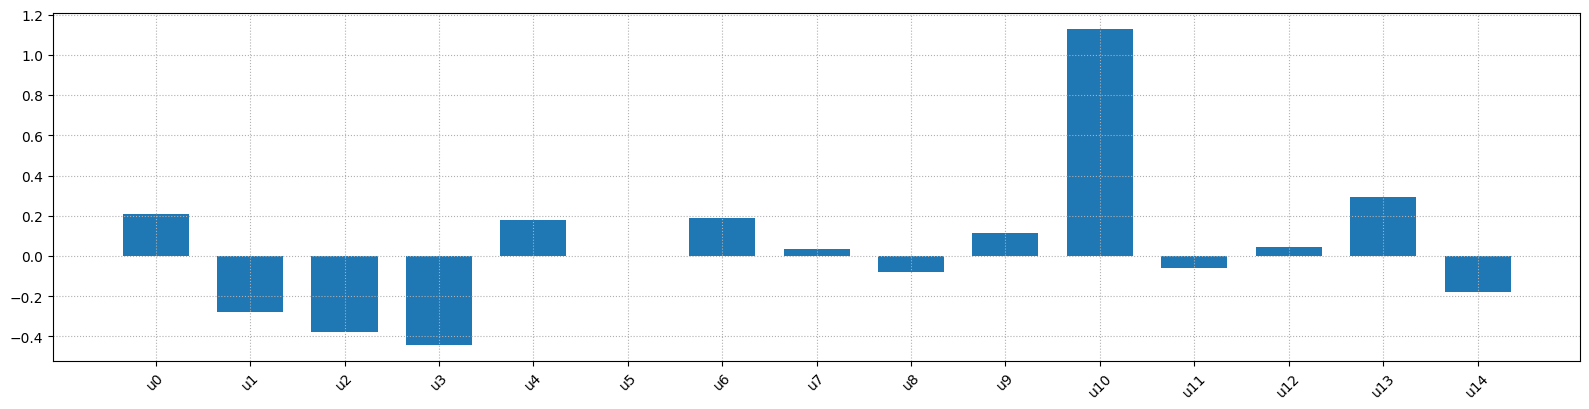

In [33]:
lr_coefs = pd.Series(index=X.columns, data=lr.coef_[0])
util.plot_bars(lr_coefs, figsize=figsize)

* Some variables seem to be more important than others
* The sign tells us how they are linked to the target

<div class=big>
<span class=small>This baseline approach has <i>many</i> issues</span><br>
Can you spot a few ones?
</div>

## Three Key Issues with our Baseline

**Issue 1: our model has _poor accuracy_**

* An AUC score of 0.6 is not much above random
* ...Hence, studying our model will say little about the data

**Issue 2: our model can only capture _linear correlations_**

* We can capture neither non-linear effects
* ...Nor interactions among the variables

**Issue 3: the coefficients are not sparse**

* The L1 terms needs both to sparsify and to prevent overfitting
* ...And it cannot do both things effectively
* Additionally: it's unclear what a good level of sparsification might be

<div class=big>
We'll now get to work to fix them
</div>

# Biomedical Data Analysis

### Intepretability with Non-Linear Models

## Dealing with Non-Linearities

**We'll start by switching to a non-linear model**

By doing so:

* We can still account for non-linear correlations
* We can account for interactions among variables
* We might reach a much better accuracy
* ...And hence have a more representative proxy model

**Of course there is a price to pay**

* Non-linear models are less easy to interpret
* ...And they are at a much higher risk of overfitting

## Gradient Boosted Trees Model

**We'll train a Gradient Bossted Trees model**

We'll rely on the Extreme Gradient Boosting package ([XGBoost](https://xgboost.readthedocs.io/en/stable/)) for this

In [34]:
base_est = xgboost.XGBRegressor(objective='reg:logistic', tree_method='hist', importance_type='total_gain')
param_grid={'max_depth': [2, 3, 4], 'n_estimators': list(range(20, 41, 5)), 'reg_lambda': np.linspace(0, 1000, 6)}
gscv = GridSearchCV(base_est, param_grid=param_grid, scoring='roc_auc')
gscv.fit(X, y)
xbm, xbm_params = gscv.best_estimator_, gscv.best_params_

**XGBoost is a library for fast, distributed, training of GBT models**

It has support for _multiple loss functions_

* We are using "reg:logistic", which refers binary cross-entropy

...And for _regularization_ (often missing in tree-based models)

* The "reg_lambda" parameter refers to the weight of an L2 regularization term
* ...Which in GBT is applied [to the leaf labels](https://xgboost.readthedocs.io/en/stable/tutorials/model.html)

## Gradient Boosted Trees Model

**It's easier to see how regularization work by checking a tree in the ensemble**

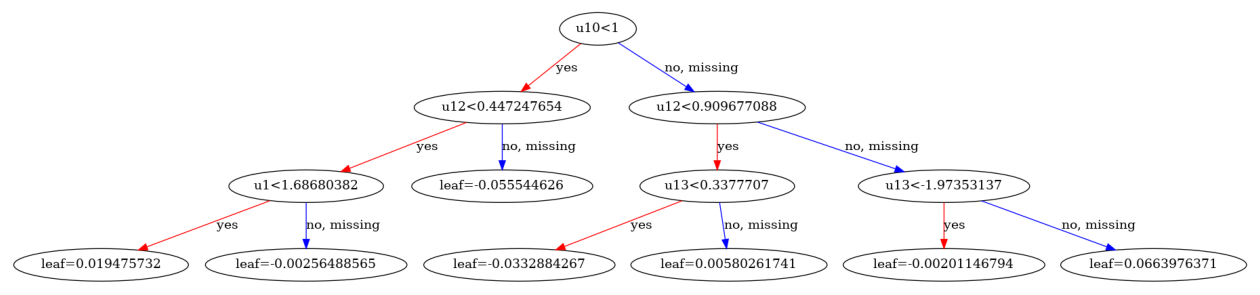

In [35]:
plt.figure(figsize=figsize)
xgboost.plot_tree(xbm, ax=plt.gca(), num_trees=0);

* Assuming $T$ is the number of leaves and $w_j$ is the label assigned to each leaf
* ...Then the regularization term is in the form $\sum_{k=1}^T w_j^2$

## Gradient Boosted Trees Model

**On our dataset, a GBT model has substantially better performance**

In [36]:
xbm_score_cv, xbm_score_test = gscv.best_score_, roc_auc_score(y_test, xbm.predict(X_test))
print(f'AUC score for {xbm_params}: {xbm_score_cv:.2f} (cross-validation), {xbm_score_test:.2f} (test)')

AUC score for {'max_depth': 3, 'n_estimators': 25, 'reg_lambda': 200.0}: 0.81 (cross-validation), 0.79 (test)


* The AUC score is much higher now
* There is no significant overfitting

**It seems we finally have a model that we can trust**

However, we know have an ensemble of many non-linear models

> **How can we make sense of that?**

## Feature Importances

**The first option one can probably think of is using _feature importances_**

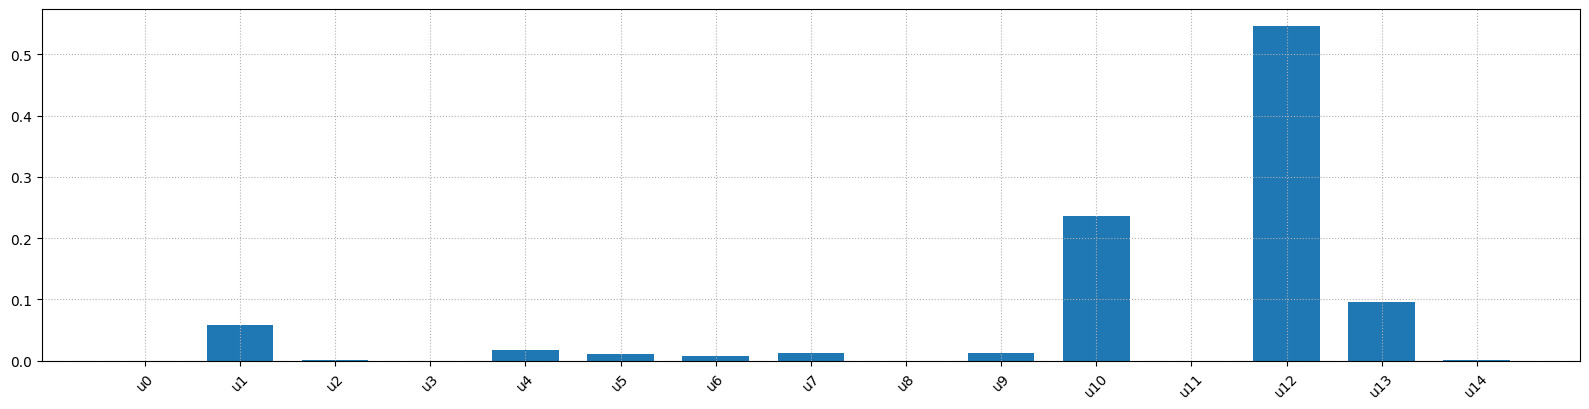

In [37]:
xbm_imp = pd.Series(index=X.columns, data=xbm.feature_importances_)
util.plot_bars(xbm_imp, figsize=figsize)

* The scores differ significanly from those obtained for linear regression (as expected)
* ...But what do they represent?

## Which Feature Importances?

**Feature importance is typicaly presented as this:**

* For each input $x_j$, we sum the associated _gain_ at training time
* Once training is over, we normalize the scores so that they sum up to 1

**However, there are _other ways to define importance_**

XGBoost supports 5 different approaches:

* "weight": number of times an attribute is used to split
* "gain": average gain associated to splits over an attribute
* "cover": average number of examples for which an attribute is used to decide
* "total_gain": as above, but replacing the average with a sum
* "total_cover": as above, but replacing the average with a sum

## Which Feature Importances?

**The values of the multiple feature importances can be quite different:**

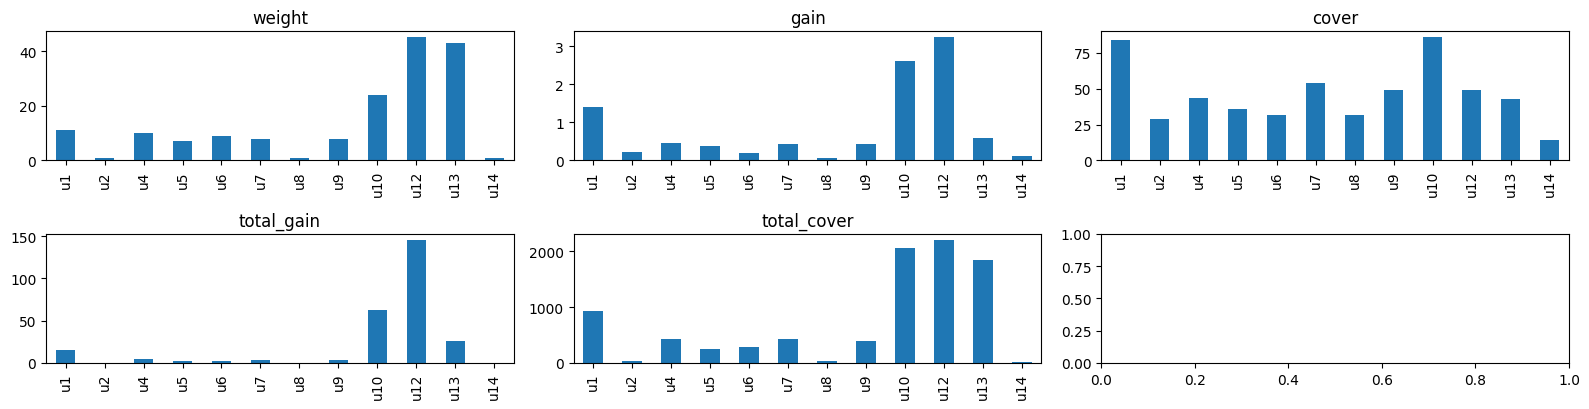

In [38]:
_, axes = plt.subplots(nrows=2, ncols=3, figsize=figsize)
for ax, imp_type in zip(axes.ravel(), ['weight', 'gain', 'cover', 'total_gain', 'total_cover']):
    pd.Series(xbm.get_booster().get_score(importance_type=imp_type)).plot.bar(ax=ax, title=imp_type)
plt.tight_layout()

## Importance and Data

**Moreover, most importance scores are computed _w.r.t. a dataset:_**

E.g. in XGBoost "gain", "cover", "total_gain", and "total_cover"

* For this reason, they are not really properties of the model
* ...But rather of the model and a reference sample

This means that the score semantic _depends on the reference sample_

**By default, importances are computed on the training set**

...Which means they are _susceptible to overfitting_

* The model might split on an attribute because it really is importance
* ...But also due to a [spurious correlation](https://www.tylervigen.com/spurious-correlations)

## Permutation Importance

**We can improve things by changing the way we compute importance**

Given a _reference sample_ $\{x_i, y_i\}_{i=1}^m$

* We can evaluate the performance of our model on the sample
* ...With that of a modified sample where the $j$-th input is _made_ unimportant

**For example, we can achieve that by _permuting_ the values of the input**

* This will preserve the distribution of the input
* ...But it will break all its correlations

**Then, we look at the change in the model performance**

* If it is small, the attribute is really unimportant
* Otherwise, the attribute is important

**These scores are known as _permutation importances_**

## Permutation Importance

**Permutation importances are robust w.r.t. spurious correlations**

* We just need to repeat the process multiple times
* ...And record means and standard deviations

It's unlikely that we get a high score very often by accident

**They allow us to _choose_ our reference sample:**

On the _training_ set, the model might have overfit over the data

* The performance gap will be wider
* ...And the score will reflect how the model _is using_ the data

On the _test set_, overfitting will make less of a different

* ...And the score will reflect how correlated the attribute is with the target

## Permutation Importances, on our Example

**Let's check the _training_ permutation importances in our case study**

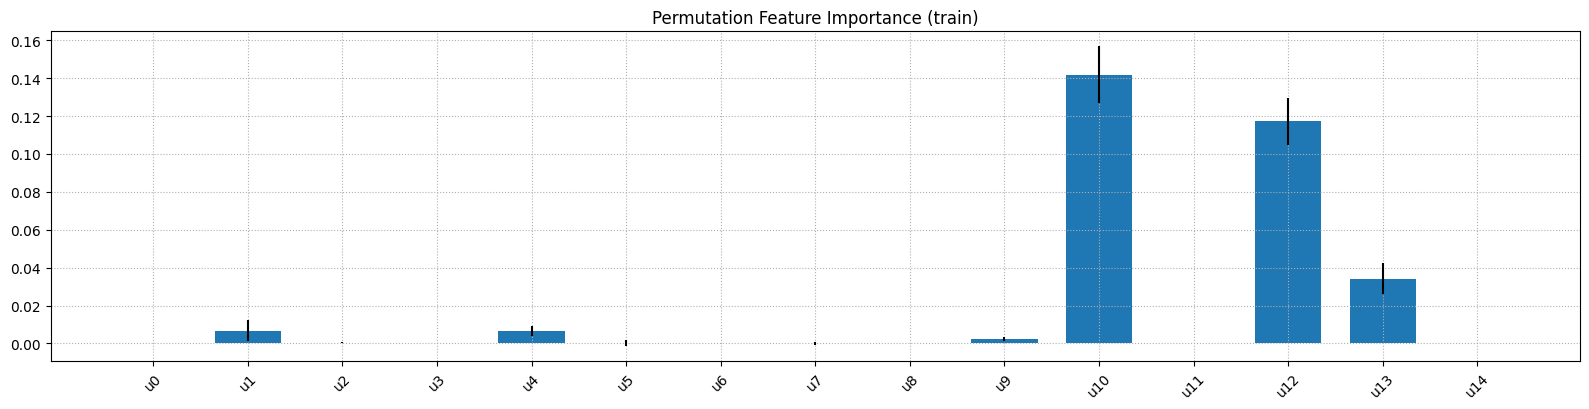

In [44]:
r_train = permutation_importance(xbm, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)
util.plot_bars(xbm_p_imp, figsize=figsize, std=r_train.importances_std, title='Permutation Feature Importance (train)')

* The closely resemble those XGB "total_gain", but they are more sparse

## Permutation Importances, on our Example

**Let's check the _test_ permutation importances in our case study**

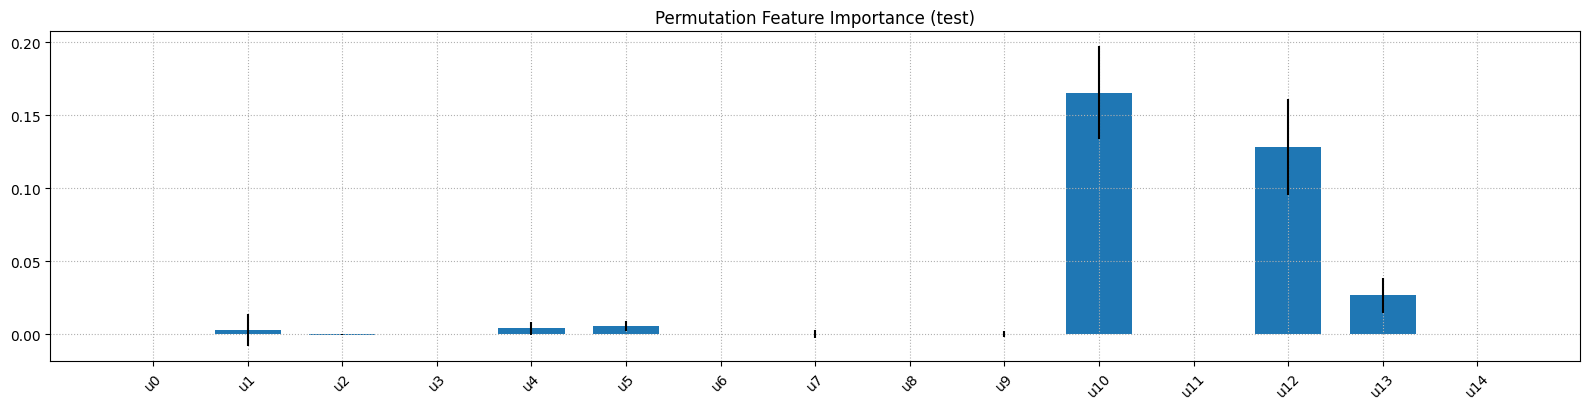

In [45]:
r_test = permutation_importance(xbm, X_test, y_test, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_test.importances_mean)
util.plot_bars(xbm_p_imp, figsize=figsize, std=r_test.importances_std, title='Permutation Feature Importance (test)')

* A few low-importance features become even less relevant on the test data

# Biomedical Data Analysis

### Additive Feature Attribution

## What we Gained, What we Lost

**When we switched from Logistic Regression to GBTs we gained a lot**

* A reliable proxy model
* A well defined and transparent feature importance definition
* Sparse and reliable importance scores

**However, we also lost something:**

With Linear Regression, we used to be able to:

* Identify the _direction_ of the correlation (through the coefficient sign)
* ...And explain _individual examples_, by looking at the difference:

$$
\theta^T x - \mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right]
$$

## Explaining Individual Examples

**Let's look again at the last equation:**

$$
\theta^T x - \mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right]
$$

* Assuming $P(X)$ is approximated by using a sample...
* ...Then $\mathbb{E}_{x^\prime \in P(X)} \left[ \theta^T x^\prime \right]$ is just the average prediction on the data

I.e. it is the prediction we could make _without access to any input value_

**Therefore, the difference above represents the gap between:**

* ...What we can predict given all information on one example
* ...And what we can predict with no such information

It's the collective _value of all available information_

## Additive Feature Attribution

**Given an example $x$, we can try to to the same:**

$$
g(z, x) = \phi_0 + \sum_{j = 1}^n \phi_{j}(x) z_j \quad\text{with: } z_{j} \in \{0, 1\}
$$

* Where $z_j = 1$ is the value of attribute $j$ is known
* ...$z_j = 0$ is the value of attribute $j$ is unknown
* ...And $\phi_j(x)$ is the _effect_ of attribute $j$ on the example $x$

**Intuitively, we build a _linear explaination_ for the model local behavior**

* There are a few approaches to approximate the effect $\phi_j(x)$
* The one we'll use work by averaging the effect of unknown attributes
* The idea is based on the Game Theory notion of Shapely Value

## SHAP

**Using Shapely values for explanation became prominent with [this paper](https://papers.nips.cc/paper_files/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)**

The work makes a number of contributions:

* It introduces the general idea of additive feature attribution
* It shows how several previous approaches fall into that category
* It show how Shapely values provide "ideal" attribution scores
* It introduces multiple techniques to approximate the values

**Computing Shapely values can be very expensive:**

...But the can still be approximated in the general case. We will:

* Consider limited size of example for averaging out unknown attributes
* Obtain a Shapely value approximation by training a local linear model

## SHAP in Action

**The authors of the SHAP paper maintain [a nice Python package](https://github.com/shap/shap)**

...Which we are going to use to _explain_ our non-linear model

In [47]:
f = lambda x: xbm.predict(x)
explainer = shap.KernelExplainer(f, shap.sample(X_train, 100), link='logit')
shap_values = explainer(X_test)
with open(os.path.join('..', 'data', 'shap_values.pickle'), 'wb') as fp:
    pickle.dump(shap_values, fp)

  0%|          | 0/100 [00:00<?, ?it/s]

* We'll focus on the _test_ data, since we want to find the true correlates
* For classifiers, it easier to explain _logits_ rather than probabilities
* The process can be slow, and using a small backgrond set is recommended
* The result contains the Shapely values, the base values, and the original data

## Waterfall Plots

**The SHAP library allows us to build _waterfall plots_**

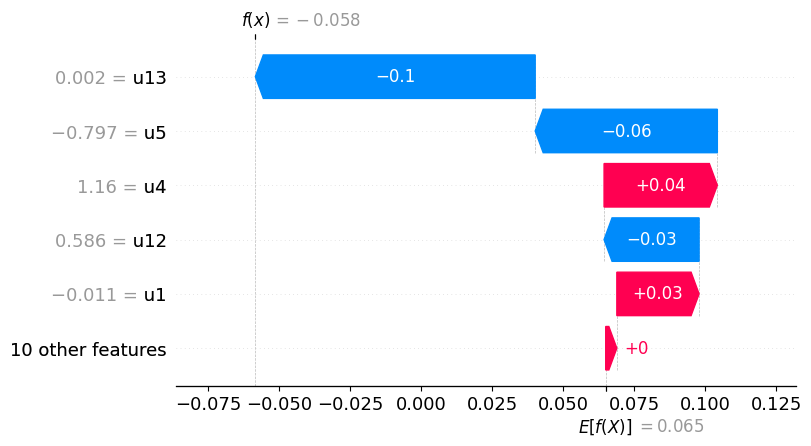

In [48]:
shap.plots.waterfall(shap_values[0], max_display=6)

* The bars represent the Shapely values, the colors their sign

## Force Plots

**Waterfall plots can be "compacted" into _force plots_**

Here we have again a plot for example 0:

In [49]:
shap.initjs()
shap.plots.force(shap_values[0])

...And have a plot for example 99

In [51]:
shap.plots.force(shap_values[99])

## Global Force Plots

**Force plots can be stacked to inspect many examples at once:**

In [52]:
shap.plots.force(shap_values)

## Scatter Plots

**We can use _scatter plots_ to show the effect of a single feature**

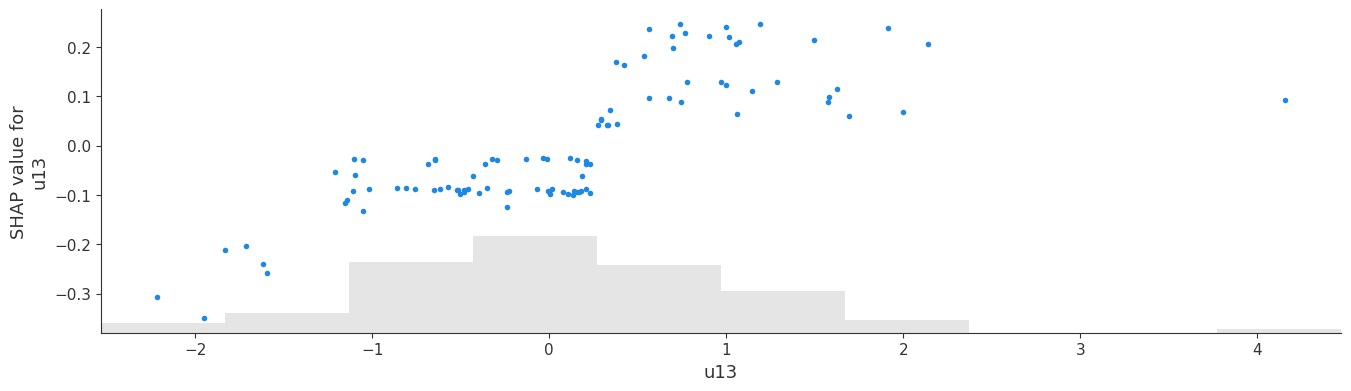

In [53]:
plt.figure(figsize=figsize)
shap.plots.scatter(shap_values[:, 'u13'], ax=plt.gca())

* The gray area is the histogram of the chosen feature

## Beeswarm (Summary) Plot

**We can stack (and color) multiple scatter plots to obtain a _beeswarm_ plot:**

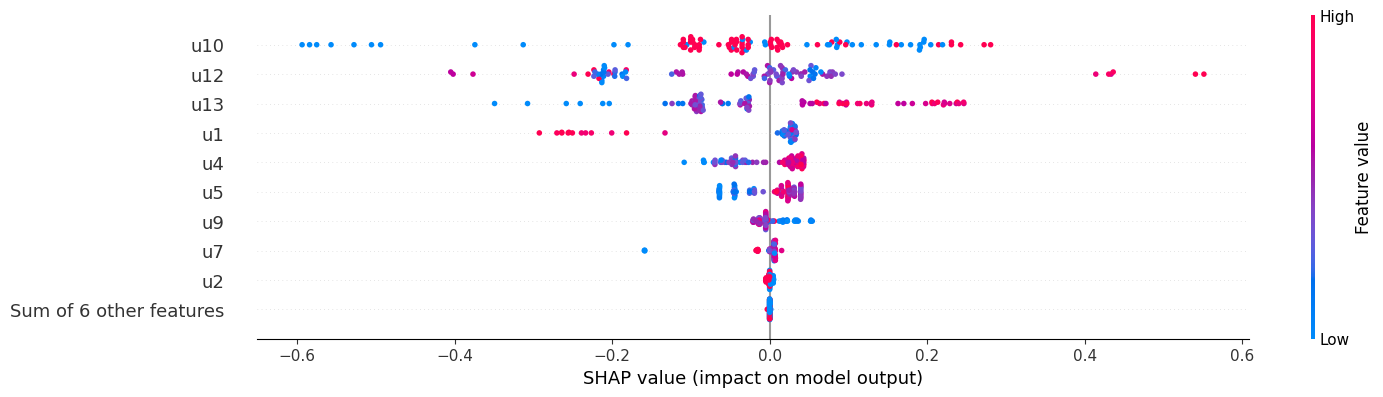

In [54]:
shap.plots.beeswarm(shap_values, max_display=10, plot_size=figsize)

* By checking the color distribution we can indentify linear and non-linear effects

## Scatter (Dependency) Plots

**We can color scatter plots _by using another feature_ to highlight dependency**

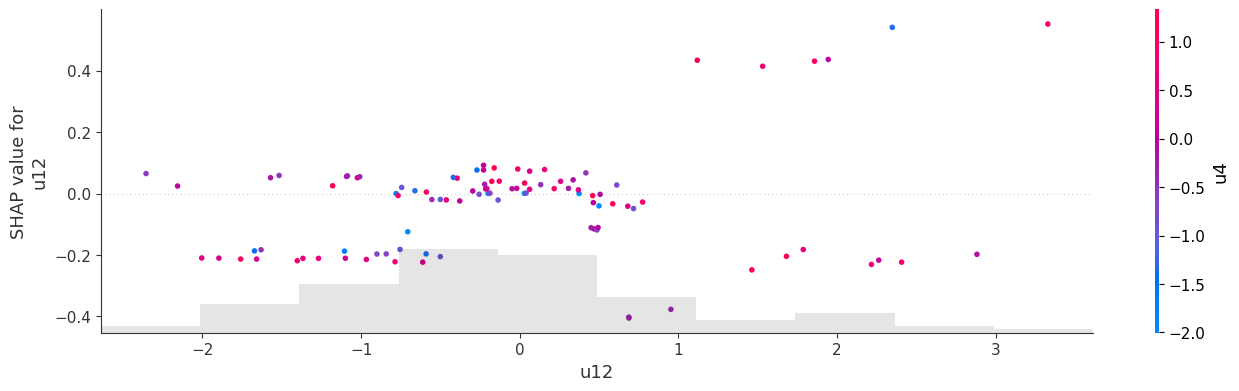

In [55]:
plt.figure(figsize=figsize)
shap.plots.scatter(shap_values[:, 'u12'], color=shap_values[:, 'u4'], ax=plt.gca())

* In this case we are coloring the "u12" values by using "u4"

## Scatter (Dependency) Plots

**We can let the library choose the best coloring feature**

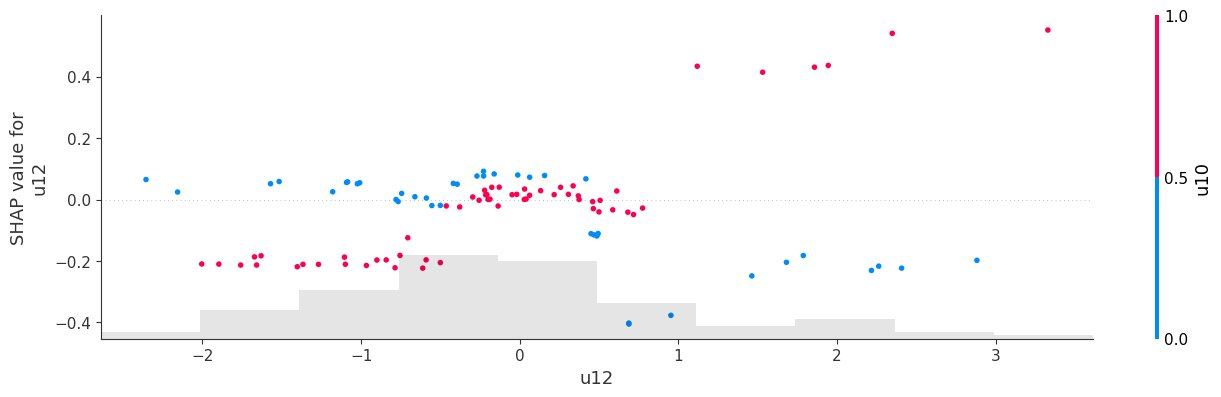

In [56]:
plt.figure(figsize=figsize)
shap.plots.scatter(shap_values[:, 'u12'], color=shap_values, ax=plt.gca())

* The chosen coloring feature changes how "u12" impacts the output in a noticeable way

## Global Feature Analysis via SHAP

**SHAP explanations can be aggreated to get global importance scores**

By default, this is done by averaring absolute SHAP values:

$$
\bar{\phi}_j(x) = \frac{1}{n} \sum_{i=1}^m |\phi_j(x_i)|
$$

* Other aggregation functions can also be used (e.g. max)

**By using aggregated SHAP scores**

...We ensure that our local and global analysis have _a similar semantic_

* Permutation Importance are a perfectly viable approach
* ...And sometimes may be more appropriate than SHAP

However, when doing a rigorous analysis consistency is important

## Global Feature Analysis via SHAP

**The SHAP library provide convenience functions to plot aggregated values**

Here's how to plot mean (absolute) SHAP values:

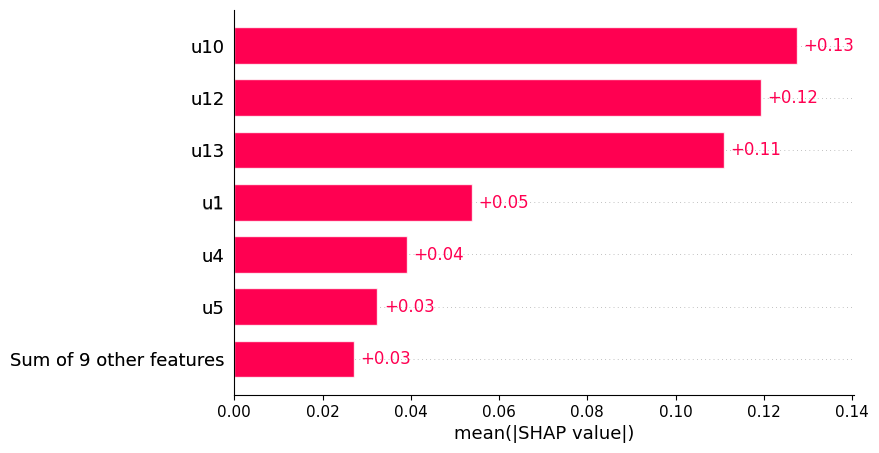

In [58]:
shap.plots.bar(shap_values, max_display=7)

# Biomedical Data Analysis

### Wrapping Up

## What we Have Discovered

**So far, we found that:**

* The 4 relevant most relevant features seem to be $U_1, U_{10}, U_{12}, U_{13}$

**By inspecting the data we found that:**

* $U_{12}$ and $U_{13}$ are roughly Normally distributed
* $U_1$ is not Normally distributed
* $U_{10}$ is binary

**By using SHAP we found that:**

* $U_{13}$ has a mostly monotonic effect
* $U_{12}$ has a complex effect, which seems to be modulated by $U_{10}$
* $U_1$ seems to have mostly an anti-monotonic effect

<div class=big>
We can now inspect the ground truth process<br>
<small>So we can check whether our results actually hold</small>
</div>

## Checking the Ground Truth

**The ground-truth process is described by this causal graph:**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

* The $Y$ variable (in <strong style="color: DeepSkyBlue">blue</strong>) is the target
* The variables in <strong>black</strong> are those that are relevant
* The variables in <strong style="color: DimGray">gray</strong> are not observable, i.e. latent
* The variables in <strong style="color: FireBrick">red</strong> are irrelevant

## Checking the Ground Truth

**The process was engineered to contain several classical cases**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

$X_2$ is a _mediator_ beween $X_0, X_1$ and $Y$

* The variable partially hides the effect of $X_0$ and $X_1$
* If it does that completely, even Boruta cannot mark $X_0$ and $X_1$ as important
* Depending on the use case, this might be an issue

## Checking the Ground Truth

**The process was engineered to contain several classical cases**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

$X_2$ is also a complete mediator for $Z_0$

* ...But in this case it is a good thing!
* $Z_0$ is not observed, but we can account for that at least indirectly

## Checking the Ground Truth

**The process was engineered to contain several classical cases**

<center>
    <img src="assets/causal_graph.png" width="35%">
</center>

$Z_1$ is a _confounder_ and causes a correlation between $X_1$ and $X_0$

* It is totally mediated by $X_1$, which is a good thing
* ...But it also causes a correlation between $X_0$ and $X_4$
* This might trick a model into considering $X_4$ as important

## Checking the Ground Truth

**In detail, the data is generated as follows:**

$$\begin{align}
Z_0 & \sim \mathcal{N}(\mu=0, \sigma=1.5) \\
Z_1 & \sim \mathcal{N}(\mu=0, \sigma=1) \\
X_0 & \sim \mathcal{N}(\mu=0, \sigma=1) + Z_1 \\
\log X_1 & \sim \mathcal{N}(\mu=0, \sigma=1) \\
X_2 & = {^1/_2} (X_0 + X_1) + Z_0 \\
X_3 & \sim B(p=0.6) \\
logit Y & \sim (-1+2 X_3) X_2 + 0.4 X_0 - 0.4 X_1
\end{align}$$

* All other variables are follow either a Normal or Bernoulli distribution
* ...And they have sparse correlations among themselves

## Checking the Ground Truth

**Now let's check how accurate our importance estimate is:**

<center>
    <img src="assets/causal_graph.png" width="30%">
</center>

In [63]:
accepted = ['u1', 'u10', 'u12', 'u13']
print(f'The most relevant features are {accepted}')
print(f'...And correspond to {[name_map[f] for f in accepted]}')

The most relevant features are ['u1', 'u10', 'u12', 'u13']
...And correspond to ['X1', 'X3', 'X2', 'X0']


## What we Have Discovered

**Now, let's check our findings, with the due substitutions:**

* The relevant features are $X_0, X_1, X_2, X_3$ $\rightarrow$ **correct!**
* All claims on distributions $\rightarrow$ **mostly correct!**
  - $X_2$ is a sum of 3 variables, two of which are Normal
* $X_0$ has a mostly monotonic effect $\rightarrow$ **correct!**
  - Direct monotonic effect on $Y$ + a complex one mediated by $X_2$
* $X_1$ has a mostly anti-monotonic effect $\rightarrow$ **correct!**
  - Direct anti-monotonic effect on $Y$ + a complex one mediated by $X_2$
* $X_2$ has complex effect modulated by $X_3$ $\rightarrow$ **correct!**
  - $X_3$ decides the sign of the $X_2$ contribution

## A Few Final Remarks

**ML models are not just for prediction!**

* They can be used for generation, anomaly detection, decision support
* ...And also as tools for a scientific analysis!

**Explainability is an important topic in AI**

* It is one of the main approaches to make an AI model _transparent_
* This critical when AI systems need to interact with human users
* ...And for some domains it is also required by existing regulations

**Beware of correlated features**

* Strongly correlated features (e.g mediated-mediator) may mislead algorithms
* Dealing with those is still a partially open problem!